In [1]:
# imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd


# Add the project root to Python path dynamically
# This finds the project root by looking for setup.py
current_dir = Path.cwd()
project_root = None

# Look for setup.py starting from current directory and going up
for parent in [current_dir] + list(current_dir.parents):
    if (parent / "setup.py").exists():
        project_root = parent
        break

if project_root is None:
    # Fallback: assume we're in src/example_files and go up 2 levels
    project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else current_dir.parent.parent

sys.path.insert(0, str(project_root))

# Now we can import from src
from src.core_functionality.data_processing import DataProcessingCSV
from src.core_functionality.spectrum import Spectrum, Spectra
from src.core_functionality.baseline_correction import ARPLS
from src.core_functionality.chemometrics import Chemometrics, FIT_PARAMETERS, CONFIDENCE_INTERVALS
from src.core_functionality.phase import Phase
from src.core_functionality.rate_data import RateData
from src.core_functionality.baseline_correction import ARPLS

print(f"All imports successful! Project root: {project_root}")

All imports successful! Project root: c:\Users\alw7s\Git\PyMESpec


In [2]:
# Path to DRIFTS data
path = project_root / "src" / "example_files" / "UV_vis_match_NAP_XPS" 


In [3]:
# Names of the CSV columns to read
csv_frequency_column = "frequency"
csv_intensity_column = "intensity"
# The initial and final rows to investigate (-1 means the last row with data)
csv_row_num_start = 1
csv_row_num_end = -1
# The spectral coordinate range to investigate (the subset of frequency values)
spectral_coordinate_start = 300
spectral_coordinate_end = 700
# Of all the data points collected this is the range of frames to investigate
starting_frame = 0
ending_frame = -1
# This is the number of data points collected per pulse in this experiment
# How frequently the data was collected in seconds
collection_dt = 0.25

print(f"Looking for data in: {path}")
print(f"Path exists: {path.exists()}")

Looking for data in: c:\Users\alw7s\Git\PyMESpec\src\example_files\UV_vis_match_NAP_XPS
Path exists: True


In [4]:
# Initialize the data processor and read the spectra
data_processor = DataProcessingCSV(
    in_dir=path,
    csv_frequency_column=csv_frequency_column,
    csv_intensity_column=csv_intensity_column,
    csv_row_num_start=csv_row_num_start,
    csv_row_num_end=csv_row_num_end,
)

spectra = data_processor.get_spectra()

print(f" Number of spectra: {len(spectra)}")
print(f" First spectrum name: {spectra[0].name}")
print(f" Second spectrum name: {spectra[1].name}")
print(f"Third spectrum name: {spectra[2].name}")

 Number of spectra: 10
 First spectrum name: uv_0
 Second spectrum name: uv_252
Third spectrum name: uv_432


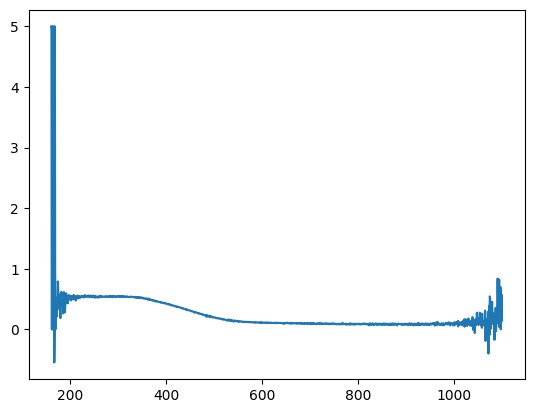

In [5]:
plt.plot(spectra.frequencies, spectra[0].intensities)

In [6]:
# Fractions of pure components from NAP-XPS analysis
fract_path = project_root / "src" / "example_files" / "XPS" / "XPS_fractions.csv"

df = pd.read_csv(fract_path, skiprows=[1])

# Extract arrays
xps_time = df["XPS Time"].to_numpy()
v5_plus  = df["V5+"].to_numpy()
v4_plus  = df["V4+"].to_numpy()
v3_plus  = df["V3+"].to_numpy()

print(xps_time)
print(v5_plus)
print(v4_plus)
print(v3_plus)

[  0  21  36  50  64  78  93 107 121 136]
[0.90677 0.59797 0.36349 0.31211 0.21437 0.20546 0.08946 0.06881 0.11694
 0.12879]
[0.05052 0.30862 0.52448 0.54458 0.6521  0.72025 0.77678 0.80192 0.75103
 0.75986]
[0.04271 0.09341 0.11203 0.14331 0.13353 0.0743  0.13376 0.12927 0.13203
 0.11135]


In [7]:
# Slice the section of the spectra that we actually want to investigate
spectra = spectra.isolate_spectra_sections([(spectral_coordinate_start, spectral_coordinate_end)])

In [8]:
chemo = Chemometrics()
pure_component_spectra = chemo.compute_reference_spectra(
    composite_spectra=spectra,
    matrix_of_pure_component_fractions=np.array([v5_plus, v4_plus, v3_plus]).T
)
print(f" Number of pure component spectra: {len(pure_component_spectra)}")

 Number of pure component spectra: 3


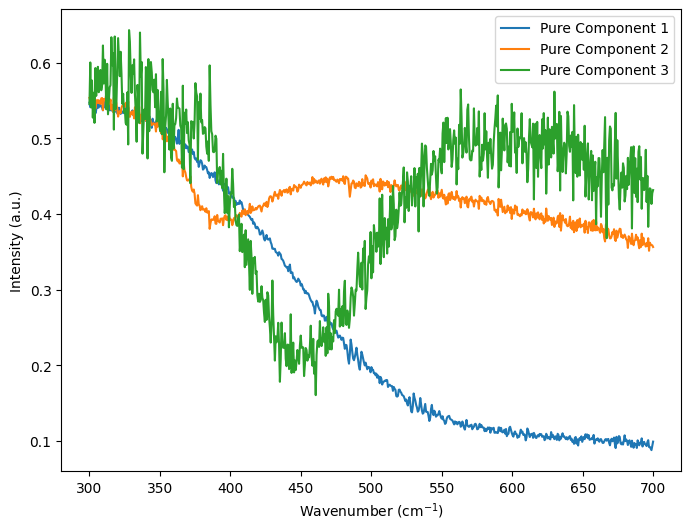

In [9]:
# Plotted visualization of the pure component spectra for V5+, V4+, and V3+

plt.figure(figsize=(8, 6))
for i, spec in enumerate(pure_component_spectra):
    plt.plot(
        spec.frequencies,
        spec.intensities,
        label=f"Pure Component {i+1}"
    )

plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.legend()


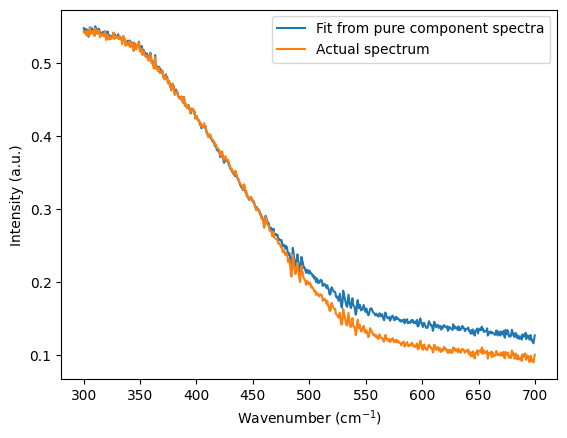

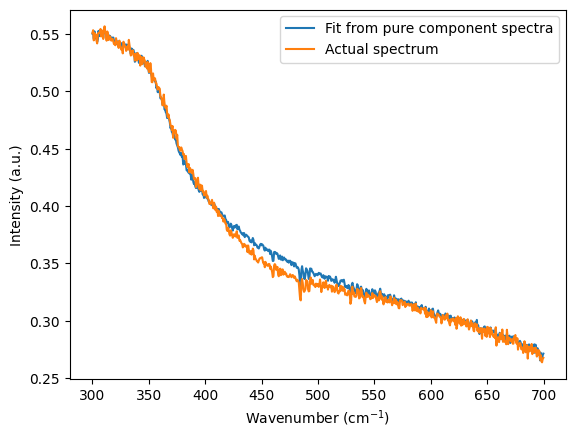

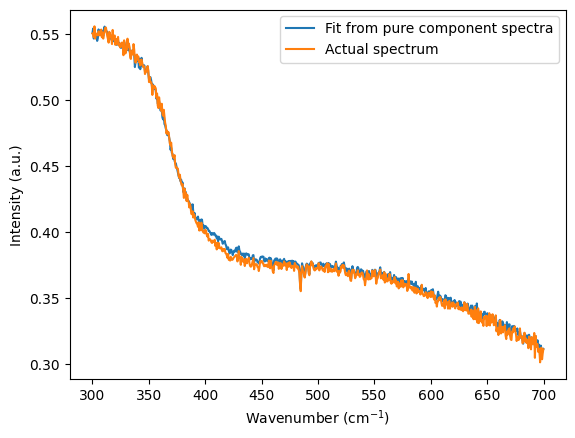

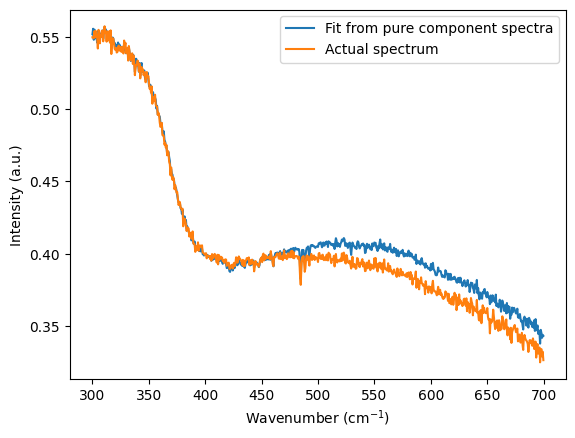

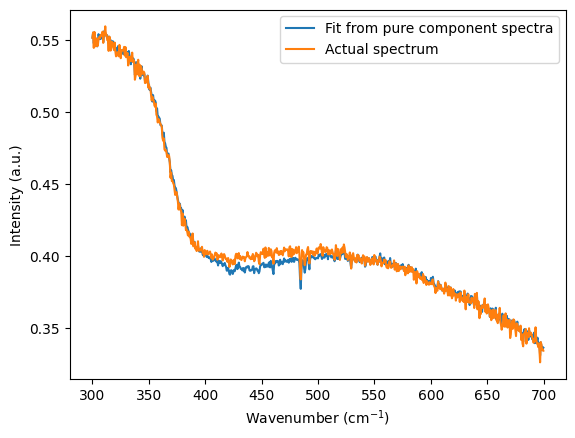

In [10]:
# Plot every other spectrum to visualize some of the fits
for i in range(len(spectra) //2):
      fit2 = v5_plus[i*2] * pure_component_spectra[0].intensities + \
            v4_plus[i*2] * pure_component_spectra[1].intensities + \
            v3_plus[i*2] * pure_component_spectra[2].intensities
      plt.figure(i)
      plt.plot(pure_component_spectra.frequencies, fit2,label='Fit from pure component spectra')
      plt.plot(spectra.frequencies, spectra[i*2].intensities,label='Actual spectrum')
      plt.xlabel("Wavenumber (cm$^{-1}$)")
      plt.ylabel("Intensity (a.u.)")
      plt.legend()